In [22]:
push!(LOAD_PATH,"../../../ExoJulia/")
push!(LOAD_PATH,".")

using Exojulia
using PyPlot

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [109]:
function chisq(x::Array{Float64,1},y::Array{Float64,1},err::Array{Float64,1},model::Function,params::Vector)
    # Compute the simple chi-squared ln likelihood
    
    res = 0.0
    
    res = sum(((y .- model(x,y,err,params)).^2.0)./(err.*err))
    
    return res
end

chisq (generic function with 1 method)

In [143]:
function affine_inv_mcmc(nsteps::Int,params::Vector,model::Function,errors::Vector;
    walk_scale::Int=3,lnlike::Function=chisq)
    #
    # Run an affine-invariant markov chain:
    # Foreman-Mackey et al. (2014) - 'emc' 'mcmc hammer'
    #
    # errors : Vector
    #   Vector of errors on initial params guess
    #
    
    nparam = length(params)
    
    # Want walkers to be a few time the number of params
    nwalkers = nparam * walk_scale
    
    # Set up arrays to hold the results:
    par_mcmc = zeros(nwalkers,nsteps,nparam)
    ln_mcmc = zeros(nwalkers,nsteps)
    
    # Initialize walkers:
    par_trial = params 
    
    # Estimate best ln like from input params
    ln_best = lnlike(x,y,err,model,par_trial)
    
    for j=1:nwalkers
        # Select from within uncertainties:
        ln_trial = 1.0e100
    
        # Only initiate models with reasonable ln like values:
        while ln_trial > (ln_best + 1000.0)
            par_trial = params + errors.*randn(nparam) 
            ln_trial = lnlike(x,y,err,model,par_trial)
        end
      
        ln_mcmc[j,1] = ln_trial
        par_mcmc[j,1,:] = par_trial
        println("Success: ",par_trial,ln_trial)
    end
    
    # Initialize scale length & acceptance counter:
    ascale = 2.0
    accept = 0
    
    # Next, loop over steps in markov chain:
    for i=2:nsteps
        for j=1:nwalkers
            ipartner = j
    
        # Choose another walker to 'breed' a trial step with:
        while ipartner == j
            ipartner = ceil(Int,rand()*nwalkers)
        end
    
        # Now, choose a new set of parameters for the trial step:
        z = (rand()*(sqrt(ascale)-1.0/sqrt(ascale))+1.0/sqrt(ascale))^2
        par_trial = vec(z*par_mcmc[j,i-1,:]+(1.0-z)*par_mcmc[ipartner,i-1,:])
    
        # Compute model & chi-square:  
        ln_trial = lnlike(x,y,err,model,par_trial)
    
        # Next, determine whether to accept this trial step:
        alp = z^(nparam-1)*exp(-0.5*(ln_trial - ln_mcmc[j,i-1]))
        if alp >= rand()
    
            # If step is accepted, add it to the chains!
            par_mcmc[j,i,:] = par_trial
            ln_mcmc[j,i,:] = ln_trial
            accept = accept + 1
       
        # If step is rejected, then copy last step:
        else
            par_mcmc[j,i,:] = par_mcmc[j,i-1,:]
            ln_mcmc[j,i,:] = ln_mcmc[j,i-1]
        end
      end
      
      if mod(i,5000) == 0
          frac_acc = accept/(5000*nwalkers)
          println("Number of steps: ",i," acceptance rate: ",frac_acc)
          ascale = 1.0 + (frac_acc/0.25)*(ascale-1.0)
          accept = 0
      end
    end
    
    return par_mcmc, ln_mcmc, nwalkers, nparam
end

affine_inv_mcmc (generic function with 4 methods)

In [142]:
function est_burnin(par_mcmc::Array{Float64,3},nwalkers::Int,nparam::Int,nsteps::Int)
    # Now, determine time of burn-in by calculating first time median is crossed:
    
    iburn = 0
    for i=1:nparam
      med_param=median(par_mcmc[1:nwalkers,1:nsteps,i])
      for j=1:nwalkers
        istep=2
        while (par_mcmc[j,istep,i] > med_param) == (par_mcmc[j,istep-1,i] > med_param) && (istep < nsteps)
          istep=istep+1
        end
        if istep >= iburn
          iburn = istep
        end
      end
    end
   
    return iburn
    
end

est_burnin (generic function with 3 methods)

# Test out the above MCMC routine by fitting to some simple sinusoidal data.

In [102]:
function test_model(x::Array{Float64,1},y::Array{Float64,1},err::Array{Float64,1},params::Vector)
    return params[1].*sin(x .- params[2])
end

test_model (generic function with 1 method)

### Generate some fake data and plot it.

In [65]:
test_amp = 2.0 # params[0]
test_phase = pi/3.0 # params[1]

#y += yerr * np.random.randn(N)

N = 100

test_x = collect(linspace(0,10,N));

test_yerr = (0.25 + 0.5*rand(N)) .* randn(N); # normally distributed noise

test_y = test_amp.*sin(test_x .- test_phase) .+ test_yerr;

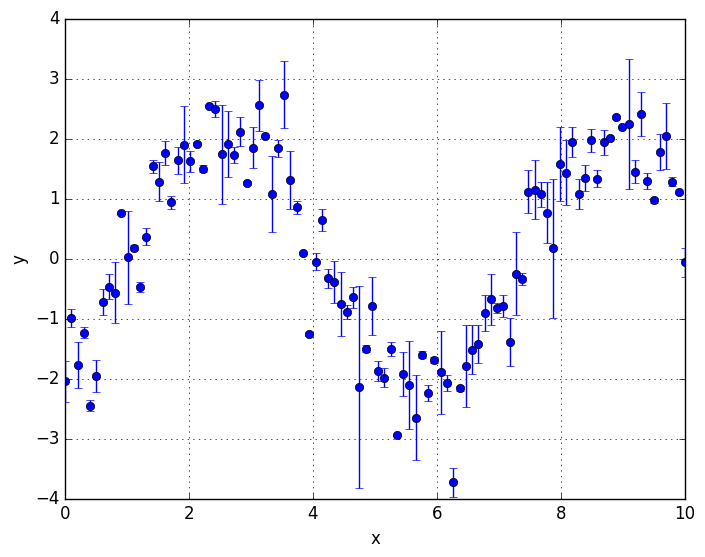

In [66]:
errorbar(test_x,test_y,yerr=yerr,fmt="o")

xlabel("x")
ylabel("y")
grid(true)

### Write wrapper for our synthetic model for MCMC calling!

In [145]:
function fit_test_model(nsteps::Int,time::Array{Float64,1},data::Array{Float64,1},sigma::Array{Float64,1})
    global x = time
    global y = data
    global err = sigma
    
    params = [1.0, pi]
    errors = [0.5, 0.5]
    
    return affine_inv_mcmc(nsteps,params,test_model,errors)
end

fit_test_model (generic function with 2 methods)

In [146]:
nsteps = 50000
par_mcmc, lnlike_mcmc, nwalkers, nparam = fit_test_model(nsteps,test_x,test_y,test_yerr)

Success: [1.0077006204044736,2.945699297740498]93531.59634945184
Success: [1.5245444971919215,2.4510698016370647]58448.208528858835
Success: [1.0880253591530575,2.7396845895740882]79260.21154690473
Success: [1.562260167834485,2.643718882966824]76920.95127895889
Success: [1.457366235983693,2.6222648352898283]73485.19263154239
Success: [1.1152386680793922,2.291422154186303]48260.46733092405
Number of steps: 5000 acceptance rate: 0.7124666666666667
Number of steps: 10000 acceptance rate: 0.49733333333333335
Number of steps: 15000 acceptance rate: 0.3736
Number of steps: 20000 acceptance rate: 0.3105
Number of steps: 25000 acceptance rate: 0.28023333333333333
Number of steps: 30000 acceptance rate: 0.26393333333333335
Number of steps: 35000 acceptance rate: 0.2588
Number of steps: 40000 acceptance rate: 0.24763333333333334
Number of steps: 45000 acceptance rate: 0.24683333333333332
Number of steps: 50000

(
6x50000x2 Array{Float64,3}:
[:, :, 1] =
 1.0077   1.06344   1.06344   1.06344   …  1.998    1.998    2.00745  2.00745
 1.52454  1.65938   1.6861    1.6861       2.00659  2.00659  2.00659  2.00659
 1.08803  1.08803   1.08803   1.08803      1.99367  2.00388  2.00388  2.00388
 1.56226  1.56226   1.56226   1.39787      2.00848  2.00848  2.00929  2.00929
 1.45737  1.43297   1.61417   1.85044      2.00838  2.00838  2.00082  1.99847
 1.11524  0.894563  0.894563  0.883585  …  2.00548  2.00548  2.00497  2.00589

[:, :, 2] =
 2.9457   2.89236  2.89236  2.89236  …  1.05548  1.05548  1.04593  1.04593
 2.45107  2.36192  2.2844   2.2844      1.04306  1.04306  1.04306  1.04306
 2.73968  2.73968  2.73968  2.73968     1.04075  1.04688  1.04688  1.04688
 2.64372  2.64372  2.64372  2.51416     1.04963  1.04963  1.05245  1.05245
 2.62226  2.61728  2.48239  2.36685     1.04498  1.04498  1.05263  1.05705
 2.29142  2.11751  2.11751  2.06714  …  1.06048  1.06048  1.05612  1.04865,

6x50000 Array{Float64,2}:

 acceptance rate: 0.25743333333333335


In [151]:
iburn = est_burnin(par_mcmc,nwalkers,nparam,nsteps)
println(iburn)

pavg = mean(vec(par_mcmc[1:nwalkers,iburn:nsteps,1]));
psig = std(vec(par_mcmc[1:nwalkers,iburn:nsteps,1]));
@printf "Amp: %8.4f +/- %8.4f\n" pavg psig

pavg = mean(vec(par_mcmc[1:nwalkers,iburn:nsteps,2]));
psig = std(vec(par_mcmc[1:nwalkers,iburn:nsteps,2]));
@printf "Phase: %8.4f +/- %8.4f\n" pavg psig

119
Amp:   2.0060 +/-   0.0076
Phase:   1.0456 +/-   0.0058


In [152]:
pi/3.0

1.0471975511965976